![](images/container-nlp.png)

## Initialize (Variables and Libraries)

In [1]:
PROJECT_ID = "vtxdemos"
STAGING_FOLDER_URI =  "gs://vtxdemos-staging"
IMAGE_URI = "gcr.io/vtxdemos/tensorflow-gpu-nlp:v1"
MODEL_URI = "gs://vtxdemos-models/nlp"

In [2]:
from google.cloud import aiplatform as aip

## Creating Folder Structure for Training Script

In [3]:
!rm -fr training
!mkdir training

In [4]:
%%writefile training/train.py
##%%
import os
import json
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from google.cloud import bigquery
import tensorflow_datasets as tfds
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

client = bigquery.Client(project="vtxdemos")

## Loading testing dataset from bigquery
sql = "select * from `public.train_nlp`"
train_df = client.query(sql).to_dataframe()
train_examples = np.array([i.encode('utf-8') for i in train_df['text']], dtype="object")
train_labels = train_df['labels'].to_numpy(dtype=int)

## Loading testing dataset from bigquery
sql = "select * from `vtxdemos.public.train_nlp`"
test_df = client.query(sql).to_dataframe()
test_examples = np.array([i.encode('utf-8') for i in test_df['text']], dtype="object")
test_labels = test_df['labels'].to_numpy(dtype=int)

## Load pre-trained model (BERT)
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)

## Splitting datasets
x_val = train_examples[:10000]
partial_x_train = train_examples[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## Create new nn layers
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

##%%
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[callback])
model.save(os.getenv('AIP_MODEL_DIR'))

with open('/gcs/vtxdemos-models/nlp/history.json', 'w') as f:
    json.dump(history.history, f)

Writing training/train.py


In [5]:
%%writefile training/requirements.txt
tensorflow==2.11.0
tensorflow_hub
tensorflow-datasets
numpy
pandas
google-cloud-bigquery
db-dtypes

Writing training/requirements.txt


In [6]:
%%writefile training/Dockerfile
FROM nvidia/cuda:11.8.0-cudnn8-devel-ubuntu22.04
ARG DEBIAN_FRONTEND=noninteractive

COPY train.py train.py
COPY requirements.txt requirements.txt
RUN apt update -y
RUN apt-get install -y python3.10 && \
     apt-get install -y python3-pip
RUN pip install -r requirements.txt

CMD ["python3", "train.py"]

Writing training/Dockerfile


In [ ]:
!docker build -t $IMAGE_URI training/.
!docker push $IMAGE_URI

In [ ]:
aip.init(project=PROJECT_ID, staging_bucket=STAGING_FOLDER_URI)

worker_pool_specs = [
    {
        "machine_spec": {
            "machine_type" : "n1-standard-8",
            "accelerator_type": "NVIDIA_TESLA_T4",
            "accelerator_count": 1
        },
        "replica_count": "1",
        "container_spec": {
            "image_uri" : IMAGE_URI
        }
    }
]


job = aip.CustomJob(
    display_name="tensorflow-gpu-nlp",
    worker_pool_specs=worker_pool_specs,
    base_output_dir=MODEL_URI,
)

job.run()

## Validating Performance Locally

In [10]:
!gsutil cp $MODEL_URI/history.json .

Copying gs://vtxdemos-models/nlp/history.json...
/ [1 files][  1.6 KiB/  1.6 KiB]                                                
Operation completed over 1 objects/1.6 KiB.                                      


In [12]:
import json

with open('history.json', 'r') as f:
    history = json.load(f)

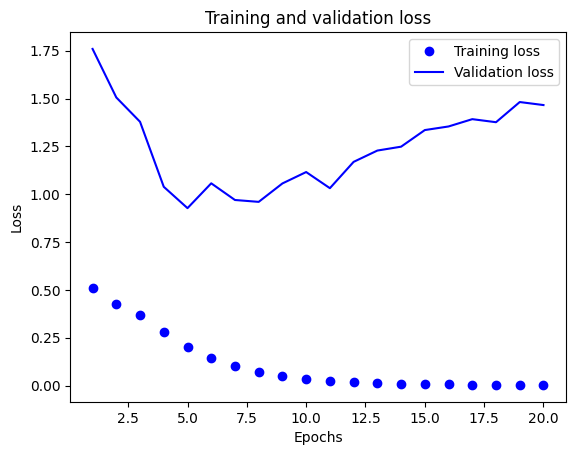

In [13]:
from matplotlib import pyplot as plt

acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

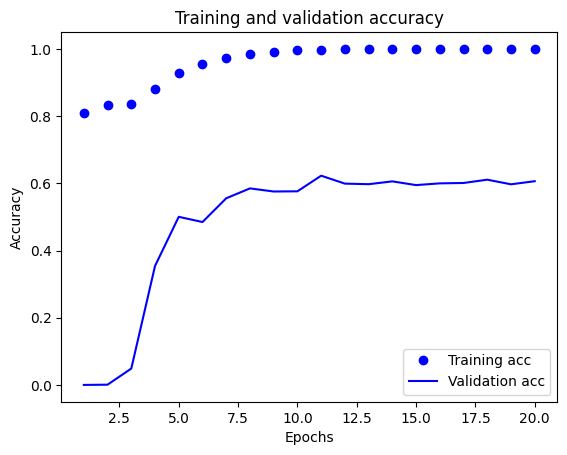

In [14]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Upload Model From Google Cloud Storage

### Create Container for Vertex Predictions

In [ ]:
!rm -fr prediction
!mkdir prediction

In [ ]:
!writefile

In [20]:
model = aip.Model.upload(
    display_name = 'cb-nlp-tf2',
    serving_container_image_uri = "us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-11:latest",
    artifact_uri = f'{MODEL_URI}/model',
)

Creating Model
Create Model backing LRO: projects/254356041555/locations/us-central1/models/8938671093028225024/operations/8272465796484038656
Model created. Resource name: projects/254356041555/locations/us-central1/models/8938671093028225024@1
To use this Model in another session:
model = aiplatform.Model('projects/254356041555/locations/us-central1/models/8938671093028225024@1')


In [22]:
endpoint = model.deploy(
    deployed_model_display_name = 'cb-nlp-tf2-end',
    traffic_percentage = 100,
    machine_type = 'n1-standard-4',
    min_replica_count = 1,
    max_replica_count = 1,
)

Creating Endpoint
Create Endpoint backing LRO: projects/254356041555/locations/us-central1/endpoints/5500632373391261696/operations/4629053697941307392
Endpoint created. Resource name: projects/254356041555/locations/us-central1/endpoints/5500632373391261696
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/254356041555/locations/us-central1/endpoints/5500632373391261696')
Deploying model to Endpoint : projects/254356041555/locations/us-central1/endpoints/5500632373391261696
Deploy Endpoint model backing LRO: projects/254356041555/locations/us-central1/endpoints/5500632373391261696/operations/7565400654986870784
Endpoint model deployed. Resource name: projects/254356041555/locations/us-central1/endpoints/5500632373391261696


In [27]:
## Testing

import numpy as np

string="This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
request = {"instances": np.array([string.encode('utf-8')], dtype='object')}
endpoint.predict(request)

Prediction(predictions=[[-0.768929064]], deployed_model_id='6501018629876744192', model_version_id='1', model_resource_name='projects/254356041555/locations/us-central1/models/8938671093028225024', explanations=None)

In [28]:
request

{'instances': array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."],
       dtype=object)}

![](images/prediction.png)

## Cleaning

In [33]:
endpoint.undeploy_all()

Undeploying Endpoint model: projects/254356041555/locations/us-central1/endpoints/5500632373391261696
Undeploy Endpoint model backing LRO: projects/254356041555/locations/us-central1/endpoints/5500632373391261696/operations/8779120754563219456
Endpoint model undeployed. Resource name: projects/254356041555/locations/us-central1/endpoints/5500632373391261696


resource name: projects/254356041555/locations/us-central1/endpoints/5500632373391261696

In [34]:
endpoint.delete()

Deleting Endpoint : projects/254356041555/locations/us-central1/endpoints/5500632373391261696
Delete Endpoint  backing LRO: projects/254356041555/locations/us-central1/operations/9197392569955254272
Endpoint deleted. . Resource name: projects/254356041555/locations/us-central1/endpoints/5500632373391261696


In [15]:
!rm -fr training